In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as skmetrics

In [2]:
df_train = pd.read_csv("data/adult.data")
df_test = pd.read_csv("data/adult.test")

In [3]:
df_train.shape

(32561, 15)

In [4]:
df_test.shape

(16281, 15)

In [5]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
df_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
df_train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income            object
dtype: object

## Transforma target em 0 e 1 para treino

In [8]:
df_train['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [9]:
rule_0 = df_train['income'] == ' <=50K'
rule_1 = df_train['income'] == ' >50K'

df_train.loc[rule_0, 'income'] = 0
df_train.loc[rule_1, 'income'] = 1

In [10]:
df_train['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

## Transforma target em 0 e 1 para teste

In [11]:
df_test['income'].value_counts()

 <=50K.    12435
 >50K.      3846
Name: income, dtype: int64

In [12]:
rule_0 = df_test['income'] == ' <=50K.'
rule_1 = df_test['income'] == ' >50K.'

df_test.loc[rule_0, 'income'] = 0
df_test.loc[rule_1, 'income'] = 1

In [13]:
df_test['income'].value_counts()

0    12435
1     3846
Name: income, dtype: int64

## Separa target das variáveis preditoras

In [14]:
def split_X_and_y(df):
    y = df['income']
    X = df.drop(columns=['income'])
    
    return X, y

In [15]:
X_train, y_train = split_X_and_y(df_train)

In [16]:
X_test, y_test = split_X_and_y(df_test)

## Modelagem

In [17]:
used_variables = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [18]:
model = KNeighborsClassifier(n_neighbors=12)

In [19]:
model.fit(X_train[used_variables], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

## Predições

In [20]:
# treino
y_pred_train = model.predict(X_train[used_variables])
y_pred_prob_train = model.predict_proba(X_train[used_variables])[:, 1]

In [21]:
# teste
y_pred_test = model.predict(X_test[used_variables])
y_pred_prob_test = model.predict_proba(X_test[used_variables])[:, 1]

In [22]:
np.unique(y_pred_train, return_counts=True)

(array([0, 1]), array([29995,  2566]))

In [23]:
np.unique(y_pred_test, return_counts=True)

(array([0, 1]), array([15086,  1195]))

## Avaliação

In [24]:
def _calculate_roc_auc(y_true, y_score):
    fpr, tpr, _ = skmetrics.roc_curve(y_true, y_score)

    return skmetrics.auc(fpr, tpr), fpr, tpr

In [25]:
def plot_roc_comparisson(y_true_1, y_score_1, y_true_2, y_score_2, figsize=(10, 8)):
    """
    * Plots ROC
    * Returns AUC
    """
    roc_auc_1, fpr_1, tpr_1 = _calculate_roc_auc(y_true_1, y_score_1)
    roc_auc_2, fpr_2, tpr_2 = _calculate_roc_auc(y_true_2, y_score_2)

    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr_1, tpr_1, color='darkorange', lw=lw, label='ROC curve for train (area = %0.4f)' % roc_auc_1)
    plt.plot(fpr_2, tpr_2, color='g', lw=lw, label='ROC curve for test\ (area = %0.4f)' % roc_auc_2)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN Classifier')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc_1, roc_auc_2

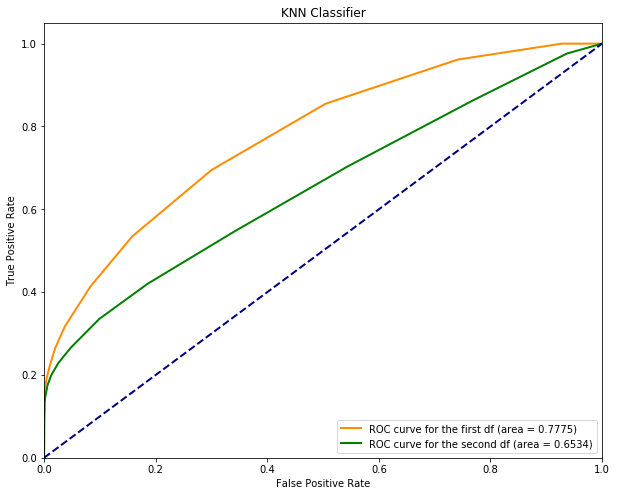

(0.777501130890692, 0.6534412015805119)

In [26]:
plot_roc_comparisson(y_train, y_pred_prob_train, y_test, y_pred_prob_test)